In [ ]:
from collections import Counter, defaultdict

import pandas as pd
import re
import string
import spacy
import matplotlib.pyplot as plt
import pytextrank
import seaborn as sns
from wordcloud import WordCloud
import stylecloud
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_md")

import sys
sys.path.insert(0, '../src')
from text_operations import TextPreprocessor, ComplexityComputer
import data_manipulation as dm

In [ ]:
df = pd.read_csv("../../data_collection/data/labelled/masters_data_programs_india_usa.csv")
df.head(3)

,uni_name,pgm_name,dur_yrs,type,national_rank_qs,dept_involved,location,url,descr,header_tag,...,Data Visualization and Presentation,Science about Data Science,Not determinable,country,gds_score,band,subject,dept,dept_cat,id
0,Indian Institute of Science Bangalore,M.Tech. Computational and Data Science,2,Public,2,Department of Computational and Data Sciences,Karnataka,http://cds.iisc.ac.in/admissions/course-degrees/,Computational Science and Data Science are int...,"['h1', 'h2', 'h3']",...,0.090909,0.000000,0.0,India,0.166804,Band 3,Data Science,Computational and Data Sciences,Data-related,Indian Institute of Science Bangalore - M.Tech...
1,Indian Institute of Science Bangalore,M.Tech. Artificial Intelligence,2,Public,2,Departments of Computer Science and Automation...,Karnataka,https://eecs.iisc.ac.in/mtechai/,Artificial Intelligence has captured the ima...,"['h1', 'h2']",...,0.000000,0.000000,0.0,India,0.198321,Band 3,Artificial Intelligence,Electrical Communication Engineering,Engineering-related,Indian Institute of Science Bangalore - M.Tech...
2,University of Hyderabad,MBA Business Analytics,2,Public,8,School of Management Studies,Telangana,https://smsuoh.ac.in/mba/mba-business-analytics/,The School has launched a two year MBA in Bus...,"['h2', 'h4']",...,0.157143,0.014286,0.0,India,0.110902,Band 2,Business Analytics,Management Studies,Management-related,University of Hyderabad - MBA Business Analytics


## 1. Descriptive Statistics, Compute Complexity
> Computing complexity measures and other descriptive stats of the program descriptions

In [ ]:
categorical_features = [
    'id', 'type', 'country', 'band', 'subject', 'dept_cat'
]

quant_features = [
    'national_rank_qs',
]

In [ ]:
textual_complexity_df = ComplexityComputer(df.loc[0, 'descr']).get_complexity_measures()
for idx in range(1, df.shape[0]):
    temp = ComplexityComputer(df.loc[idx, 'descr']).get_complexity_measures()
    textual_complexity_df = pd.concat([textual_complexity_df, temp])

textual_complexity_df = textual_complexity_df.reset_index(drop=True)
textual_complexity_df.head()

,text,char_cnt,word_cnt,sent_cnt,digits_cnt,mean_chars_per_word,median_chars_per_word,mean_words_per_sent,median_words_per_sent,common_nouns_prop,proper_nouns_prop,adjectives_prop,verbs_prop,numerals_prop,flesch_kincaid,dale_chall,mtld
0,Computational Science and Data Science are int...,687,88,3,0,6.738636,7.0,29.333333,28.0,0.363636,0.079545,0.170455,0.090909,0.000000,21.7,11.61,46.951849
1,Artificial Intelligence has captured the ima...,1566,244,13,4,5.368852,4.0,18.769231,18.0,0.290984,0.094262,0.110656,0.098361,0.016393,14.6,10.41,79.344978
2,The School has launched a two year MBA in Bus...,2911,419,24,12,5.832936,6.0,17.458333,13.5,0.295943,0.164678,0.059666,0.081146,0.019093,17.5,9.27,59.886627
3,M.Tech Artificial Intelligence is also a four...,384,61,3,3,5.278689,4.0,20.333333,23.0,0.311475,0.049180,0.098361,0.098361,0.049180,14.4,9.76,67.280000
4,Data Science is gaining prominence in academi...,1101,159,14,5,5.767296,5.0,11.357143,10.0,0.371069,0.050314,0.088050,0.119497,0.031447,10.1,9.24,80.397106


In [ ]:
# for summary stats
textual_complexity_df.describe()

,char_cnt,word_cnt,sent_cnt,digits_cnt,mean_chars_per_word,median_chars_per_word,mean_words_per_sent,median_words_per_sent,common_nouns_prop,proper_nouns_prop,adjectives_prop,verbs_prop,numerals_prop,flesch_kincaid,dale_chall,mtld
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,1295.414414,194.162162,8.009009,2.144144,5.572910,5.090090,26.463185,24.905405,0.310078,0.083402,0.087175,0.126837,0.008591,20.419820,10.734234,74.763731
std,1025.046965,150.835283,6.673551,3.492451,0.360267,0.847987,13.098319,12.935419,0.076863,0.056788,0.031239,0.068389,0.011543,8.852301,1.364508,25.134515
min,12.000000,2.000000,1.000000,0.000000,4.585227,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.040816,0.000000,2.900000,8.090000,2.000000
25%,660.500000,94.500000,4.000000,0.000000,5.340987,4.500000,20.187500,19.000000,0.279515,0.046333,0.068947,0.095564,0.000000,15.750000,9.775000,58.918856
50%,1141.000000,175.000000,6.000000,1.000000,5.564286,5.000000,25.142857,23.000000,0.311475,0.076596,0.080717,0.119149,0.004695,18.500000,10.600000,75.776202
75%,1625.000000,253.000000,11.000000,3.000000,5.773258,6.000000,30.166667,30.000000,0.355303,0.115474,0.104037,0.136485,0.012906,21.950000,11.575000,92.085147
max,8052.000000,1182.000000,49.000000,24.000000,6.738636,7.000000,124.000000,124.000000,0.535714,0.319712,0.178571,0.500000,0.060606,54.200000,15.110000,161.000000


In [ ]:
# merge with original to form new dataframe
df_complexity_merged = pd.merge(df, textual_complexity_df, left_on='descr', right_on='text')
df_complexity_merged = df_complexity_merged.drop('text', axis=1)
df_complexity_merged.shape

(117, 48)

In [ ]:
textual_complexity_df.columns

Index(['text', 'char_cnt', 'word_cnt', 'sent_cnt', 'digits_cnt',
       'mean_chars_per_word', 'median_chars_per_word', 'mean_words_per_sent',
       'median_words_per_sent', 'common_nouns_prop', 'proper_nouns_prop',
       'adjectives_prop', 'verbs_prop', 'numerals_prop', 'flesch_kincaid',
       'dale_chall', 'mtld'],
      dtype='object')

<AxesSubplot:xlabel='word_cnt', ylabel='country'>

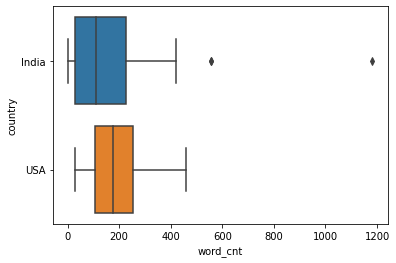

In [ ]:
sns.boxplot(data=df_complexity_merged, x='word_cnt', y='country')

## 2. Keyword Extraction from Program Descriptions

> TextRank algo used as frequency-based keyword etxraction would perform poorly in this context. Program descriptions will not have many words repeated.

In [ ]:
# key word extraction
if "textrank" not in nlp.pipe_names:
    nlp.add_pipe("textrank")

def keyword_extraction(text):

    keywords = []

    doc = nlp(text)
    for phrase in doc._.phrases:
        keywords.append(phrase.text)
    
    # extract top 15 or less keywords
    keywords = [kword.lower() for kword in keywords[:15]]
    return (";".join(keywords))

df['descr_keywords'] = df.descr.apply(keyword_extraction)

In [ ]:
df.descr_keywords.head(10)

0    scientific computing applications;applications...
1    ai research;ai;e-governance services;deep tech...
2    business analytics;business analytics programm...
3    project work;work;data mining;other emerging t...
4    trained resources;diverse research disciplines...
5    ai academics;iit hyderabad;ai;different facult...
6    problem solving;ethical practices;computer eng...
7    financial institutions;indian economics;econom...
8    business analytics programme;business analytic...
9    spatial data;geo-intelligence and business int...
Name: descr_keywords, dtype: object

In [ ]:
# for all programs
kword_string = ";".join(df.descr_keywords)
kword_freq, unique_kwords = process_keywords(kword_string)

## 3. Wordcloud Visualization of Keywords in Program Descriptions

In [ ]:
def process_keywords(kword_string, delim=';'):

    all_kwords = kword_string.split(delim)
    kword_freq = Counter(all_kwords)
    unique_kwords = list(kword_freq.keys())

    return kword_freq, unique_kwords

def plot_wordclouds(df, cat_col=None, cats=None, all_pgms=False):
    """
    Plot wordclouds of keywords
    """

    if not(all_pgms):
        for cat in cats:
            df_sub = df[df[cat_col] == cat]
            kword_string = ";".join(df_sub.descr_keywords)
            kword_freq, unique_kwords = process_keywords(kword_string)

            stylecloud.gen_stylecloud(
                text = kword_freq,
                max_words = 200,
                icon_name = 'fas fa-graduation-cap',
                colors = ['#cb001c', '#0071b3', '#ffc107', '#2f9171'],
                output_name = "wordcloud_keywords_" + cat_col + "_" + cat + ".png",
                gradient = 'horizontal',
                random_state=42)  
    else:
        kword_string = ";".join(df.descr_keywords)
        kword_freq, unique_kwords = process_keywords(kword_string)
        stylecloud.gen_stylecloud(
                text = kword_freq,
                max_words = 200,
                icon_name = 'fas fa-graduation-cap',
                colors = ['#cb001c', '#0071b3', '#ffc107', '#2f9171'],
                output_name = "wordcloud_keywords.png",
                gradient = 'horizontal',
                random_state=42)  

In [ ]:
# generate wordclouds
plot_wordclouds(df, all_pgms=True)
plot_wordclouds(df, 'type', ['Public', 'Private'])
plot_wordclouds(df, 'country', ['India', 'USA'])
plot_wordclouds(df, 'dept_cat', ["Engineering-related", "Management-related", "Data-related"])
plot_wordclouds(df, 'subject', ["Data Science", "Business Analytics", "Analytics", "Artificial Intelligence"])

## 4. Program Webpage Element Analysis

In [ ]:
webpage_elements = [
    'country', 'dept_cat', 'subject',
    'header_tag', 'header_names', 'links',
    'html_tags', 'html_tag_freq', 'html_emphasized_elements'
]
df_web = df[webpage_elements]

In [ ]:
df_web.head(3)

,country,dept_cat,subject,header_tag,header_names,links,html_tags,html_tag_freq,html_emphasized_elements
0,India,Data-related,Data Science,"['h1', 'h2', 'h3']","[['\n\t\t\tCourse Degree Admissions, 2021\t\t'...",['https://iisc.ac.in/admissions/m-tech-m-des/'...,"['header', 'h1', 'div', 'ul', 'li', 'span', 's...","{'header': 1, 'h1': 1, 'div': 1, 'ul': 6, 'li'...","['the m.tech. (cds) admission process', 'downl..."
1,India,Engineering-related,Artificial Intelligence,"['h1', 'h2']","[['MTech (AI) @ IISc'], ['Admissions 2021 – Ap...","['https://ai.iisc.ac.in', 'https://admissions-...","['h1', 'p', 'img', 'p', 'strong', 'a', 'p', 'h...","{'h1': 1, 'p': 18, 'img': 2, 'strong': 15, 'a'...",['written test will be held online with remote...
2,India,Management-related,Business Analytics,"['h2', 'h4']","[['MBA Business Analytics'], ['Highlights of t...",no links in useful area,"['article', 'div', 'h2', 'p', 'h4', 'ul', 'li'...","{'article': 1, 'div': 1, 'h2': 1, 'p': 9, 'h4'...","['guest lectures', 'semester-4', 'continuous e..."


In [ ]:
def remove_unnecessary_whitespace(text):
    text = text.replace("'", "").replace('"', '')
    text = text.replace('\\t', '').replace('\\n', '').replace('[', '').replace(']', '')
    text = re.sub(' +', ' ', text)
    text = text.translate({ord(k): ' ' for k in string.punctuation})
    text = text.strip()
    return text

def get_element_text(elements, length=False):

    text = elements.split(',')
    text = [remove_unnecessary_whitespace(g).lower() for g in text]
    text = list(set(text))
    if length:
        return len(text)
    return text

def get_element_text_str(elements):

    text = elements.split(',')
    text = [remove_unnecessary_whitespace(g).lower() for g in text]
    text = list(set(text))
    
    return ";".join(text)



In [ ]:
df_web['header_elements'] = df_web.header_names.apply(get_element_text_str)
df_web['emphasized_elements_text'] = df_web.html_emphasized_elements.apply(get_element_text_str)
df_web['num_emphasized_elements'] = df_web.html_emphasized_elements.apply(lambda x: get_element_text(x, True))
df_web['num_headers'] = df_web.header_names.apply(lambda x: get_element_text(x, True))
df_web['num_links'] = df_web.links.apply(lambda x: get_element_text(x, True))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [ ]:
df_web.head()

,country,dept_cat,subject,header_tag,header_names,links,html_tags,html_tag_freq,html_emphasized_elements,header_elements,emphasized_elements_text,num_emphasized_elements,num_headers,num_links
0,India,Data-related,Data Science,"['h1', 'h2', 'h3']","[['\n\t\t\tCourse Degree Admissions, 2021\t\t'...",['https://iisc.ac.in/admissions/m-tech-m-des/'...,"['header', 'h1', 'div', 'ul', 'li', 'span', 's...","{'header': 1, 'h1': 1, 'div': 1, 'ul': 6, 'li'...","['the m.tech. (cds) admission process', 'downl...",about the m tech cds program;2021;m tech ...,last updated on april 12;linear algebra matric...,31,5,9
1,India,Engineering-related,Artificial Intelligence,"['h1', 'h2']","[['MTech (AI) @ IISc'], ['Admissions 2021 – Ap...","['https://ai.iisc.ac.in', 'https://admissions-...","['h1', 'p', 'img', 'p', 'strong', 'a', 'p', 'h...","{'h1': 1, 'p': 18, 'img': 2, 'strong': 15, 'a'...",['written test will be held online with remote...,interview;further details;admissions 2021 – ap...,n of india applicants;international applicants...,20,5,16
2,India,Management-related,Business Analytics,"['h2', 'h4']","[['MBA Business Analytics'], ['Highlights of t...",no links in useful area,"['article', 'div', 'h2', 'p', 'h4', 'ul', 'li'...","{'article': 1, 'div': 1, 'h2': 1, 'p': 9, 'h4'...","['guest lectures', 'semester-4', 'continuous e...",placements;curriculum;continuous evaluation;hi...,semester – 3;semester 4;year – 2;placements;se...,15,8,1
3,India,Engineering-related,Artificial Intelligence,['h2'],[['Master of Technology in Artificial Intellig...,"['./mtechaiold_program.php', './mtechainew_pro...","['div', 'h2', 'p', 'b', 'ul', 'li', 'a', 'li',...","{'div': 1, 'h2': 1, 'p': 1, 'b': 1, 'ul': 1, '...","['m.tech artificial intelligence', 'master of ...",master of technology in artificial intelligence,master of technology in artificial intelligenc...,2,1,4
4,India,"Engineering-related, Statistics-related",Data Science,Not inferred,Not inferred,Not inferred,Not inferred,Not inferred,Not inferred,not inferred,not inferred,1,1,1


In [ ]:
all_tags = ";".join(df_web[df_web.country=="India"].html_tags.apply(get_element_text_str)).split(';')
pd.Series(all_tags).value_counts(normalize=True).head(20)

p               0.062718
div             0.059233
a               0.055749
li              0.055749
span            0.048780
strong          0.048780
ul              0.045296
h1              0.041812
not inferred    0.041812
h2              0.038328
td              0.034843
table           0.034843
tr              0.034843
tbody           0.031359
br              0.031359
h3              0.031359
ol              0.027875
b               0.027875
h4              0.024390
iframe          0.020906
dtype: float64

In [ ]:
all_tags = ";".join(df_web[df_web.country=="USA"].html_tags.apply(get_element_text_str)).split(';')
pd.Series(all_tags).value_counts(normalize=True).head(20)

a          0.055102
div        0.054422
p          0.054422
span       0.048299
li         0.046939
ul         0.045578
strong     0.041497
h2         0.037415
br         0.036735
img        0.036054
h1         0.035374
h3         0.032653
h4         0.026531
em         0.021769
tr         0.017687
tbody      0.017687
td         0.017687
table      0.017687
article    0.017007
nav        0.016327
dtype: float64

In [ ]:
emphasized_elements_text = ";".join(df_web.emphasized_elements_text).split(';')
emphasized_elements_text = [e.replace(";", " ") for e in emphasized_elements_text]
emphasized_elements_text = " ".join(emphasized_elements_text).split(' ')
emphasized_elements_text = [ele for ele in emphasized_elements_text if ele not in STOP_WORDS]

In [ ]:
[e for e in emphasized_elements_text if ('admission' in e or 'apply' in e)]

['admissions',
 'admissions',
 'admissions',
 'admission',
 'admissions',
 'admissions',
 'admissions',
 'admissions',
 'admissions',
 'admission',
 'admission',
 'admission',
 'admissions',
 'admissions',
 'admissions',
 'apply',
 'apply',
 'apply',
 'admission',
 'admission',
 'admission',
 'admissionsnon',
 'admissions',
 'apply',
 'admissionsnon',
 'admissions',
 'apply',
 'admissions',
 'admission',
 'admissions',
 'admissions',
 'admissions',
 'admission',
 'onlineadmissions',
 'admissions',
 'admissions',
 'apply',
 'admissions',
 'apply',
 'admissions',
 'admissions',
 'admissions',
 'admissions',
 'admission',
 'admissions',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'apply',
 'admission',
 'admissions',
 'applying',
 'admissions',
 'apply',
 'apply',
 'apply',
 'apply',
 'admission',
 'admission',
 'admission',
 'apply',
 'admission',
 'admissions',
 'admissions',
 'admissions',
 'apply',
 'apply',
 'apply',
 'apply',


In [ ]:
f = pd.Series(emphasized_elements_text)
f

0         updated
1           april
2              12
3          linear
4         algebra
          ...    
9288        smith
9289           ms
9290    marketing
9291    analytics
9292       degree
Length: 9293, dtype: object

In [ ]:
unique_emph = list(set(emphasized_elements_text))
unique_emph = [w for w in unique_words if len(w) != 0]

ohe = pd.DataFrame(columns=unique_emph)
ohe.loc[len(ohe)] = 0
for phrase in emphasized_elements_text:
    try:
        ohe[phrase]  = ohe[phrase] + 1
    except:
        pass

In [ ]:
ohe.columns

Index(['master’s in data science', 'applied business analytics faculty',
       '100%', 'mccourt school news',
       '"#8 best online masters in computer information technology programs"',
       'explore the mit sloan campus',
       'ids420. business model simulation. 3 or 4 hours.',
       'total of 30 credit hours', 'wednesday', 'engr computing access fee',
       ...
       'alumni profiles', 'september 28', 'two (2) elective courses',
       'student achievements', 'for more information:',
       'rady msba career highlights', 'list of electives',
       'ids406. business systems project. 3 or 4 hours.',
       'software development: (3 units)', '"data science masters program"'],
      dtype='object', length=1905)

In [ ]:
ohe = ohe.T

In [ ]:
ohe.columns = ['0']
ohe.sort_values(ascending=False, by='0').head(30)

,0
data,172
4,159
program,117
course,89
3,75
requirements,68
courses,65
degree,55
2,50
1,46


In [ ]:
header_text = ";".join(df_web[df_web.country=="USA"].emphasized_elements_text).split(';')
header_text = Counter([word for word in header_text if word not in STOP_WORDS])
header_text.most_common()

[('tuition', 13),
 ('application requirements', 12),
 ('curriculum', 11),
 ('application deadlines', 11),
 ('on-campus', 11),
 ('health insurance', 11),
 ('i consent to receive periodic texts from the usc viterbi school of engineering. i can opt out at any time. standard text/data rates may apply.',
  10),
 ('fee description', 10),
 ('**by providing my mobile phone number', 10),
 ('norman topping student aid fee', 10),
 ('den@viterbi', 10),
 ('exam proctoring', 10),
 ('resume/cv', 10),
 ('gre general test:', 10),
 ('student fees', 10),
 ('international students:', 10),
 ('4-unit course', 10),
 ('engr computing access fee', 10),
 ('course offerings', 10),
 ('english language proficiency:', 10),
 ('academic year', 10),
 ('personal statement', 10),
 ('mandatory fees (approximate)', 10),
 ('fee amount', 10),
 ('academic disciplines', 10),
 ('transcripts:', 10),
 ('please note: requirements for graduation', 10),
 ('3-unit course', 10),
 ('additional materials for international applicants', 

In [ ]:
header_text = ";".join(df_web[df_web.country=="India"].emphasized_elements_text).split()
header_text = Counter([word for word in header_text if word not in STOP_WORDS])
header_text.most_common()

[('data', 14),
 ('&', 11),
 ('-', 9),
 ('courses', 9),
 ('m.tech.', 8),
 ('inferred;not', 8),
 ('artificial', 7),
 ('international', 7),
 ('science', 7),
 ('admissions', 6),
 ('business', 6),
 ('online', 5),
 ('–', 5),
 ('test', 5),
 ('candidates', 5),
 ('education', 5),
 ('management', 5),
 ('nov.', 4),
 ('date', 4),
 ('center', 4),
 ('july', 4),
 ('students', 4),
 ('analytics', 4),
 ('program', 4),
 ('industry', 4),
 ('learning', 4),
 ('student', 4),
 ('requirement', 4),
 ('accounting', 4),
 ('(modular)', 4),
 ('interview', 3),
 ('@', 3),
 ('2021', 3),
 ('internship', 3),
 ('project', 3),
 ('technology', 3),
 ('following', 3),
 ('mba', 3),
 ('spatial', 3),
 ('elective', 3),
 ('list', 3),
 ('ai', 3),
 ('mtech', 3),
 ('electives', 3),
 ('areas', 3),
 ('(cse)', 3),
 ('specialization', 3),
 ('analysis', 3),
 ('dbms', 3),
 ('april', 2),
 ('(cds)', 2),
 ('shortlisted', 2),
 ('admission', 2),
 ('(artificial', 2),
 ('ability', 2),
 ('held', 2),
 ('2021;semester', 2),
 ('curriculum', 2),
 ('p

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=596b9f0a-2431-4aa3-878c-95287ebfbe9a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>